In [1]:
import torch
from torch import nn
import torchvision
import copy



In [2]:
torch.cuda.is_available()

False

# ** Importing Resnet Model


In [ ]:
resnet18 = torchvision.models.resnet18()
resnet34= torchvision.models.resnet18()
resnet50= torchvision.models.resnet50()


In [ ]:
resnet18_BYOL = torchvision.models.resnet18()

# note that we need to create exactly the same backbone in order to load the weights
backbone_BYOL = nn.Sequential(
    *list(resnet18_BYOL.children())[:-1],
)
ckpt = torch.load('/content/drive/MyDrive/Project/Models/BYOL_MODELS/BYOL(85,25EPOCHS,lr=0.06)model.pth')
backbone_BYOL.load_state_dict(ckpt['resnet18_parameters'])

<All keys matched successfully>

In [ ]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#Giving path 
images_path ='/content/drive/MyDrive/Project/Dataset/train_models'
anno_path = '/content/drive/MyDrive/Project/Dataset/train_models'

In [ ]:
#Functions to read xml files

def filelist(root, file_type):
    """Returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = float(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = float(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = float(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = float(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

In [ ]:
#df_train2=pd.read_csv('/content/drive/MyDrive/data/Training.csv')

In [ ]:
df_train = generate_train_df(anno_path)

In [ ]:
#from keras.preprocessing import image

In [ ]:
#img = image.load_img("/content/drive/MyDrive/data/train2/AdjustableClamp/014380.jpg", target_size=(224, 224))

# Convert the image to a numpy array
#x = image.img_to_array(img)

In [ ]:
#x.reshape()

In [ ]:
#del df_train['index']

In [ ]:
#df_train2.to_csv('/content/drive/MyDrive/training_demo/images/Training.csv')

In [ ]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,88.4094,157.6528,232.7188,251.2139
1,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,89.5047,155.4167,229.8281,246.6083
2,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,98.6391,154.5944,222.1297,234.7028
3,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,107.5344,155.0695,216.0078,225.2972
4,/content/drive/MyDrive/Project/Dataset/train_m...,300,300,Wire,111.0562,155.3139,214.0375,222.0083


In [ ]:
#label encode target
class_dict = {'AdjustableClamp': 0,'AdjustableWrench': 1,'Battery': 2,'Bolt': 3,'BoltNutSet': 4,'BoltWasher': 5,'ClampPart': 6,'Cutter': 7,'FuelCap': 8,'Hammer': 9,'Hose': 10,'Label': 11,'LuggagePart': 12,'LuggageTag': 13,'MetalPart': 14,'MetalSheet': 15,'Nail': 16,'Nut': 17,'PaintChip': 18,'Pen': 19,'PlasticPart': 20,'Pliers': 21,'Rock': 22,'Screw': 23,'Screwdriver': 24,'SodaCan':25,'Tape': 26,'Washer': 27,'Wire': 28,'Wood': 29,'Wrench': 30}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

In [ ]:
print(df_train.shape)
df_train.head()

(8429, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/training_demo/images/te...,300,300,25,173.8266,32.4639,219.6141,119.0416
1,/content/drive/MyDrive/training_demo/images/te...,300,300,25,65.5953,189.3861,116.7750,287.5889
2,/content/drive/MyDrive/training_demo/images/te...,300,300,25,220.8172,213.7666,268.6719,300.0000
3,/content/drive/MyDrive/training_demo/images/te...,300,300,25,102.2563,52.3472,186.8657,211.7222
4,/content/drive/MyDrive/training_demo/images/te...,300,300,25,127.6078,199.5083,173.4281,288.6139


In [ ]:
df_train[['xmin','ymin','xmax','ymax']] = df_train[['xmin','ymin','xmax','ymax']].astype(int)


In [ ]:
#df_train[['filename']] = df_train[['filename']].astype(str)

In [ ]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/training_demo/images/te...,300,300,25,173,32,219,119
1,/content/drive/MyDrive/training_demo/images/te...,300,300,25,65,189,116,287
2,/content/drive/MyDrive/training_demo/images/te...,300,300,25,220,213,268,300
3,/content/drive/MyDrive/training_demo/images/te...,300,300,25,102,52,186,211
4,/content/drive/MyDrive/training_demo/images/te...,300,300,25,127,199,173,288


## ** Data Pre-Processing Functions

In [ ]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [ ]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.int32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [ ]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [ ]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/training_demo/images/te...,300,300,25,173,32,219,119
1,/content/drive/MyDrive/training_demo/images/te...,300,300,25,65,189,116,287
2,/content/drive/MyDrive/training_demo/images/te...,300,300,25,220,213,268,300
3,/content/drive/MyDrive/training_demo/images/te...,300,300,25,102,52,186,211
4,/content/drive/MyDrive/training_demo/images/te...,300,300,25,127,199,173,288


In [ ]:
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/training_demo/images/te...,300,300,25,173,32,219,119
1,/content/drive/MyDrive/training_demo/images/te...,300,300,25,65,189,116,287
2,/content/drive/MyDrive/training_demo/images/te...,300,300,25,220,213,268,300
3,/content/drive/MyDrive/training_demo/images/te...,300,300,25,102,52,186,211
4,/content/drive/MyDrive/training_demo/images/te...,300,300,25,127,199,173,288
...,...,...,...,...,...,...,...,...
8424,/content/drive/MyDrive/training_demo/images/te...,300,300,5,81,150,109,182
8425,/content/drive/MyDrive/training_demo/images/te...,300,300,5,212,167,237,198
8426,/content/drive/MyDrive/training_demo/images/te...,300,300,5,125,226,150,257
8427,/content/drive/MyDrive/training_demo/images/te...,300,300,5,132,117,162,153


In [ ]:
#Populating Training DF with new paths and bounding boxes
new_paths = []
new_bbs = []
train_path_resized = Path('/content/drive/MyDrive/Resize/Resnet_18')
for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,/content/drive/MyDrive/training_demo/images/te...,300,300,25,173,32,219,119,/content/drive/MyDrive/Resize/Resnet_18/029672...,"[32, 257, 118, 326]"
1,/content/drive/MyDrive/training_demo/images/te...,300,300,25,65,189,116,287,/content/drive/MyDrive/Resize/Resnet_18/029607...,"[189, 96, 286, 173]"
2,/content/drive/MyDrive/training_demo/images/te...,300,300,25,220,213,268,300,/content/drive/MyDrive/Resize/Resnet_18/029712...,"[213, 327, 299, 399]"
3,/content/drive/MyDrive/training_demo/images/te...,300,300,25,102,52,186,211,/content/drive/MyDrive/Resize/Resnet_18/029755...,"[52, 151, 210, 277]"
4,/content/drive/MyDrive/training_demo/images/te...,300,300,25,127,199,173,288,/content/drive/MyDrive/Resize/Resnet_18/029727...,"[199, 188, 287, 258]"


In [ ]:
#df_train.to_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")


In [ ]:
#df_train2=pd.read_csv("/content/drive/MyDrive/resnet_resized/Upgraded Training.csv")

In [ ]:
#df_train2.drop(df_train2.columns[[0,1]], axis=1, inplace=True)


In [ ]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
print(im.shape)

(300, 300, 3)


In [ ]:
Y = create_mask(bb, im)
mask_to_bb(Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


array([ 85, 109, 203, 182], dtype=int32)

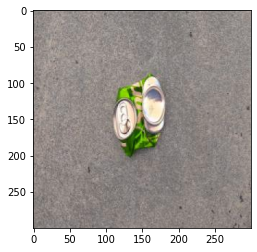

In [ ]:
plt.imshow(im)

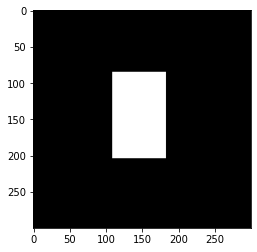

In [ ]:
plt.imshow(Y, cmap='gray')

In [ ]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [ ]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [ ]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [ ]:
df_train.info

<bound method DataFrame.info of                                                filename width height  class  \
0     /content/drive/MyDrive/training_demo/images/te...   300    300     25   
1     /content/drive/MyDrive/training_demo/images/te...   300    300     25   
2     /content/drive/MyDrive/training_demo/images/te...   300    300     25   
3     /content/drive/MyDrive/training_demo/images/te...   300    300     25   
4     /content/drive/MyDrive/training_demo/images/te...   300    300     25   
...                                                 ...   ...    ...    ...   
8424  /content/drive/MyDrive/training_demo/images/te...   300    300      5   
8425  /content/drive/MyDrive/training_demo/images/te...   300    300      5   
8426  /content/drive/MyDrive/training_demo/images/te...   300    300      5   
8427  /content/drive/MyDrive/training_demo/images/te...   300    300      5   
8428  /content/drive/MyDrive/training_demo/images/te...   300    300      5   

      xmin  ymin  x

In [ ]:
df_train.values[0][8]

'/content/drive/MyDrive/Resize/Resnet_18/029672.jpg'

In [ ]:
#original
im = cv2.imread(str(df_train.values[1][0]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, [df_train.values[1][5],df_train.values[1][4],df_train.values[1][7],df_train.values[1][6]])

error: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


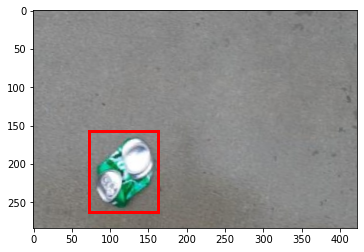

In [ ]:
# after transformation
im, bb = transformsXY(str(df_train.values[1][8]),df_train.values[1][9],True)
show_corner_bb(im, bb)

In [ ]:
bb

array([157,  73, 263, 162], dtype=int32)

In [ ]:
df_train = df_train.reset_index()

## ** SPLIT DATA

In [ ]:
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']

In [ ]:
#X.to_csv("/content/drive/MyDrive/data/Xtrain.csv")
#Y.to_csv("/content/drive/MyDrive/data/Ytrain.csv")

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_val.to_csv("/content/drive/MyDrive/data/XVal.csv")

In [ ]:
y_val.to_csv("/content/drive/MyDrive/data/YVal.csv")

In [ ]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [ ]:
class FOD(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [ ]:
train_ds = FOD(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = FOD(X_val['new_path'],X_val['new_bb'],y_val)

In [ ]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [ ]:
# import the necessary packages
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid

#Defining Model

In [ ]:
class BB_model(nn.Module):
    def __init__(self,backbone):
        super(BB_model, self).__init__()
        self.backbone=backbone
        layers = list(backbone.children())[:-1]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 31))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)


In [ ]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [ ]:
train_dl

In [ ]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    validation_accuracy=[]
    validation_loss=[]
    training_loss=[]
    Epochs_Total=[]
    evaluation_metrics=[]
    print("Start Training")
    for i in range(epochs):
        Epochs_Total.append(i)
       
        model.train()
       
        total = 0
        sum_loss = 0
       
        for x, y_class, y_bb in train_dl:
            #print("4")
            batch = y_class.shape[0]
            #print("5")
            x = x.cuda().float()
            #print("6")
            y_class = y_class.cuda()
            #print("7")
            y_bb = y_bb.cuda().float()
            #print("8")
            out_class, out_bb = model(x)
            #print("9")
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            #print("10")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            #print("11")
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
            #print("Successful Loop 1")
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
        validation_accuracy.append(val_acc)
        validation_loss.append(val_loss)
        training_loss.append(train_loss)
        #print("Successful Loop 2")
    evaluation_metrics.append(Epochs_Total)
    evaluation_metrics.append(validation_loss)
    evaluation_metrics.append(validation_accuracy)
    evaluation_metrics.append(training_loss)
    return sum_loss/total,evaluation_metrics


In [ ]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
model = BB_model(resnet18_new)
model.to(device)
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

NameError: ignored

## ** Training Model

In [ ]:
''' !pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()   '''

In [ ]:
total_loss,evaluation_metrics=train_epocs(model, optimizer, train_dl, valid_dl, epochs=15)

Start Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


train_loss 3.392 val_loss 2.941 val_acc 0.187
train_loss 2.576 val_loss 2.796 val_acc 0.253
train_loss 2.163 val_loss 2.192 val_acc 0.387
train_loss 1.738 val_loss 2.424 val_acc 0.368
train_loss 1.367 val_loss 1.505 val_acc 0.557
train_loss 1.094 val_loss 1.400 val_acc 0.622
train_loss 0.916 val_loss 1.984 val_acc 0.610
train_loss 0.717 val_loss 1.197 val_acc 0.695
train_loss 0.622 val_loss 0.779 val_acc 0.794
train_loss 0.529 val_loss 1.653 val_acc 0.677
train_loss 0.467 val_loss 0.848 val_acc 0.794
train_loss 0.400 val_loss 0.426 val_acc 0.903
train_loss 0.356 val_loss 2.953 val_acc 0.736
train_loss 0.346 val_loss 0.571 val_acc 0.875
train_loss 0.309 val_loss 2.793 val_acc 0.706


In [ ]:
evaluation_metrics

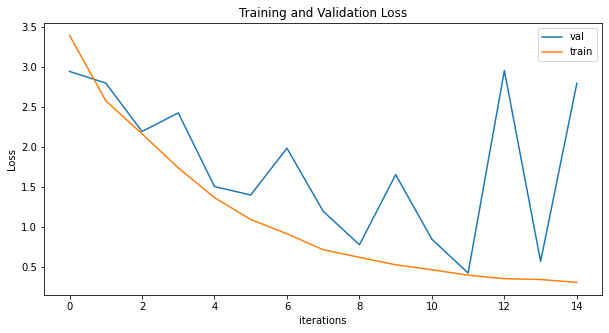

In [ ]:
import matplotlib.pyplot as plt

val_acc = [0.213,0.295,0.577,0.633,0.619,0.638,0.794,0.830,0.782,0.872,0.756,0.880,0.928,0.935,0.830]
val_losses = [2.775,3.234,1.596,1.451,3.324,1.248,0.765,0.615,0.826,0.532,1.164,0.570,0.336,0.309,0.693]
train_losses=[3.086,2.112,1.711,1.301,1.068,0.872,0.754,0.632,0.558,0.482,0.431,0.444,0.350,0.280,0.265]

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(evaluation_metrics[1],label="val")
plt.plot(evaluation_metrics[3],label="train")
#plt.plot(evaluation_metrics[2],label="val_accuracy")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

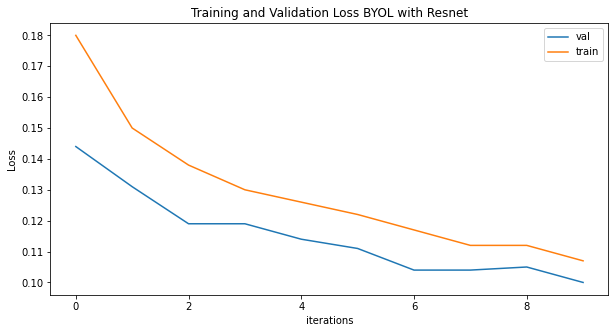

In [ ]:
import matplotlib.pyplot as plt

val_acc = [0.988,0.989,0.992,0.993,0.991,0.993,0.995,0.993,0.993]
val_losses = [0.144,0.131,0.119,0.119,0.114,0.111,0.104,0.104,0.105,0.100]
train_losses=[0.180,0.150,0.138,0.130,0.126,0.122,0.117,0.112,0.112,0.107]

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss BYOL with Resnet")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
#plt.plot(val_acc,label="val_accuracy")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
update_optimizer(optimizer, 0.001)
Final_Loss,Final_Metrics=train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

Start Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


train_loss 0.139 val_loss 0.136 val_acc 0.984
train_loss 0.129 val_loss 0.132 val_acc 0.983
train_loss 0.121 val_loss 0.117 val_acc 0.985
train_loss 0.121 val_loss 0.116 val_acc 0.988
train_loss 0.112 val_loss 0.113 val_acc 0.986
train_loss 0.105 val_loss 0.103 val_acc 0.988
train_loss 0.103 val_loss 0.115 val_acc 0.986
train_loss 0.096 val_loss 0.096 val_acc 0.991
train_loss 0.093 val_loss 0.100 val_acc 0.991
train_loss 0.089 val_loss 0.100 val_acc 0.992


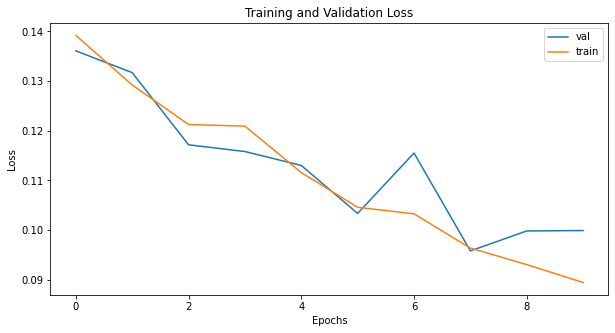

In [ ]:
import matplotlib.pyplot as plt

val_acc = [0.858,0.974,0.974,0.985,0.976,0.985,0.986,0.988,0.984,0.989]
val_losses = [0.631,0.177,0.164,0.148,0.168,0.126,0.121,0.121,0.125,0.112]
train_losses=[0.225,0.187,0.173,0.152,0.150,0.140,0.134,0.121,0.118,0.11]

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(Final_Metrics[1],label="val")
plt.plot(Final_Metrics[3],label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## ** Testing Model

In [ ]:
X_val['new_path'][712][-10:]

'032431.jpg'

In [ ]:
X_val.head()

,new_path,new_bb
712,/content/drive/MyDrive/Resize/Resnet_18/032431...,"[46, 0, 130, 222]"
1385,/content/drive/MyDrive/Resize/Resnet_18/027215...,"[41, 13, 233, 173]"
4394,/content/drive/MyDrive/Resize/Resnet_18/015237...,"[107, 187, 245, 247]"
5091,/content/drive/MyDrive/Resize/Resnet_18/009832...,"[27, 272, 40, 284]"
5964,/content/drive/MyDrive/Resize/Resnet_18/013411...,"[115, 227, 176, 335]"


In [ ]:
# resizing test image and passing it to new test folder
im = read_image(X_val['new_path'][712])
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/drive/MyDrive/test/'+X_val['new_path'][712][-10:], cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [ ]:
test_ds = FOD(pd.DataFrame([{'path':X_val['new_path'][712]}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
x, y_class, y_bb = test_ds[0]
xx = torch.FloatTensor(x[None,])
xx.shape
# prediction
out_class, out_bb = model(xx.cuda())
print(out_class)
# predicted class
torch.max(out_class, 1)

array([0., 0., 0., 0.], dtype=float32)

In [ ]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])
bb_hat[0]

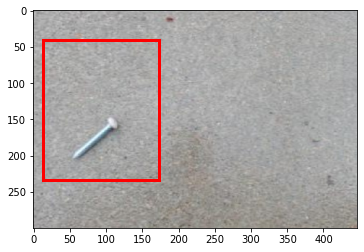

In [ ]:
# Drawing bounding box from actual
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, X_val['new_bb'][1385])

In [ ]:
# Creating Different Colours
def create_corner_rect_v2(bb, color):
    bb = np.array(bb)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

# Ground vs Predicted Bounding Boxs
def plot_two_rectangle(im,bb1,bb2):
  plt.imshow(im)
  plt.gca().add_patch(create_corner_rect_v2(bb1,color='red'))
  plt.gca().add_patch(create_corner_rect_v2(bb2,color='green'))

In [ ]:
# Reading Whole X_Val
X_val_read = pd.read_csv('/content/drive/MyDrive/data_8k/XVal.csv')
Test_data=FOD(X_val_read['new_path'],pd.DataFrame(np.zeros((1686, 4))),pd.DataFrame(np.zeros((1686, 1))))
d = pd.DataFrame(np.zeros((1686, 4)))
len(Test_data)
# resizing test image
#X_val_read['new_path'][712][:23]+'test_resize'+X_val_read['new_path'][712][-21:]
im = read_image(X_val_read['new_path'][712][:23]+'test_resize'+X_val_read['new_path'][712][-21:])
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('/content/drive/MyDrive/test/'+X_val_read['new_path'][0][-10:], cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [ ]:
Y_val_read = pd.read_csv('/content/drive/MyDrive/data_8k/YVal.csv')

In [ ]:
Y_val_read

,Unnamed: 0,class
0,712,28
1,1385,21
2,4394,3
3,5091,27
4,5964,3
...,...,...
1681,6823,11
1682,7121,5
1683,7656,7
1684,6489,21


## ** Defining Testing Metrics

In [ ]:
# Defining IOU
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])
    
    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))
    
    area_of_intersection = i_height * i_width
    
    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1
    
    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1
    
    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection
    
    iou = area_of_intersection / area_of_union
    
    return iou

In [ ]:
ground_truth_bbox = np.array([X_val['new_bb'][1385][0],X_val['new_bb'][1385][1],X_val['new_bb'][1385][2],X_val['new_bb'][1385][3]], dtype=np.float32)

prediction_bbox = np.array([bb_hat[0][0],bb_hat[0][1],bb_hat[0][2],bb_hat[0][3]], dtype=np.float32)

In [ ]:
iou = get_iou(ground_truth_bbox, prediction_bbox)
print('IOU: ', iou)

IOU:  0.6712244625450661


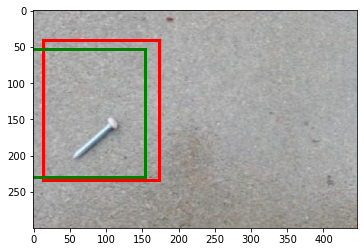

In [ ]:
# Import dependencies.
plot_two_rectangle(im,ground_truth_bbox,prediction_bbox)

In [ ]:
#Defining Confusion Matrix

## ** Saving Model

In [ ]:
#torch.save(model,"/content/drive/MyDrive/Models/Resnet18.h5")